In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

In [16]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

In [3]:
cancer = load_breast_cancer()
cancer_df = pd.DataFrame(cancer['data'], columns=cancer['feature_names'])
cancer_df['target'] = cancer['target']
cancer_df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [4]:
data = torch.from_numpy(cancer_df.values).float()
X = data[:, :-1]
y = data[:, -1:]
X.shape, y.shape

(torch.Size([569, 30]), torch.Size([569, 1]))

In [5]:
ratios = [0.6, 0.2, 0.2]

In [6]:
train_cnt = int(X.shape[0] * ratios[0])
valid_cnt = int(X.shape[0] * ratios[1])
test_cnt = X.shape[0] - train_cnt - valid_cnt
cnts = [train_cnt, valid_cnt, test_cnt]
cnts

[341, 113, 115]

In [7]:
indices = torch.randperm(X.shape[0])
X = torch.index_select(X, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)
X = list(X.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))
for X_i, y_i in zip(X, y):
    print(X_i.shape, y_i.shape)

torch.Size([341, 30]) torch.Size([341, 1])
torch.Size([113, 30]) torch.Size([113, 1])
torch.Size([115, 30]) torch.Size([115, 1])


In [8]:
scaler = StandardScaler().fit(X[0].numpy())
for i in range(3):
    X[i] = torch.from_numpy(scaler.transform(X[i].numpy())).float()
X

[tensor([[ 1.3897,  1.6881,  1.3653,  ...,  1.1253,  0.6223,  0.8300],
         [ 1.0665,  0.2849,  1.0299,  ...,  1.2804,  0.2932,  0.0919],
         [-0.6683, -0.9459, -0.6780,  ..., -0.5257, -0.1971, -0.3308],
         ...,
         [-0.7788, -0.0978, -0.8069,  ..., -0.6631, -0.8038, -1.0374],
         [ 1.7874,  2.3330,  1.9203,  ...,  2.3085,  2.0001,  2.4554],
         [-0.6048,  0.3085, -0.5646,  ...,  0.0348, -0.6957,  0.9883]]),
 tensor([[-0.9445,  0.2211, -0.8988,  ..., -0.4138, -0.4631,  0.2120],
         [-1.0854, -0.4663, -1.0765,  ..., -1.1786, -0.0259, -0.3290],
         [-1.0053, -0.0388, -0.9822,  ..., -1.2346, -0.0957, -0.4849],
         ...,
         [ 0.4422, -1.9309,  0.4309,  ...,  0.4865, -0.5428, -0.1034],
         [ 0.2018, -0.5939,  0.1151,  ..., -0.5095, -0.5960, -0.9246],
         [ 0.6549, -0.2750,  0.5827,  ..., -0.3343, -0.8138, -1.1417]]),
 tensor([[-0.3285, -0.7758, -0.3525,  ..., -0.4460,  0.6871, -0.3138],
         [-0.8810, -0.2041, -0.8632,  ..., -0

In [9]:
model = nn.Sequential(
    nn.Linear(X[0].shape[-1], 20),
    nn.LeakyReLU(),
    nn.Linear(20, 10),
    nn.LeakyReLU(),
    nn.Linear(10, 5),
    nn.LeakyReLU(),
    nn.Linear(5, y[0].shape[-1]),
    nn.Sigmoid()
)
optimizer = optim.Adam(model.parameters())

In [10]:
n_epochs = 10000
batch_size = 256
print_interval = 10

In [11]:
early_stop = 100
lowest_loss = np.inf
best_model = None
lowest_epoch = np.inf

In [12]:
train_history, valid_history = [], []

for i in range(n_epochs):
    indices = torch.randperm(X[0].shape[0])
    X_ = torch.index_select(X[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)
    X_ = X_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for X_i, y_i in zip(X_, y_):
        y_hat_i = model(X_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += float(loss)
    
    train_loss = train_loss / len(X_)

    with torch.no_grad():
        X_ = X[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for X_i, y_i in zip(X_, y_):
            y_hat_i = model(X_i)
            loss = F.binary_cross_entropy(y_hat_i, y_i)

            valid_loss += float(loss)

            y_hat += [y_hat_i]

    valid_loss = valid_loss / len(X_)

    train_history += [train_loss]
    valid_history += [valid_loss]

    if valid_loss < lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i
        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and early_stop + lowest_epoch < i + 1:
            print(f'There is no improvement during last {early_stop} epochs.')
            break

    if (i + 1) % print_interval == 0:
        print(f'Epoch {i + 1}: train loss={train_loss:.6f}, valid loss={valid_loss:.6f}, lowest loss={lowest_loss:.6f}')

print(f'The best validation loss from epoch {lowest_epoch + 1}: {lowest_loss:.6f}')

model.load_state_dict(best_model)

Epoch 10: train loss=0.652250, valid loss=0.654433, lowest loss=0.654433
Epoch 20: train loss=0.638311, valid loss=0.634529, lowest loss=0.634529
Epoch 30: train loss=0.599826, valid loss=0.583547, lowest loss=0.583547
Epoch 40: train loss=0.501905, valid loss=0.488683, lowest loss=0.488683
Epoch 50: train loss=0.385666, valid loss=0.402321, lowest loss=0.402321
Epoch 60: train loss=0.355549, valid loss=0.329535, lowest loss=0.329535
Epoch 70: train loss=0.267765, valid loss=0.243592, lowest loss=0.243592
Epoch 80: train loss=0.171813, valid loss=0.154416, lowest loss=0.154416
Epoch 90: train loss=0.106679, valid loss=0.096626, lowest loss=0.096626
Epoch 100: train loss=0.099838, valid loss=0.070306, lowest loss=0.070306
Epoch 110: train loss=0.092331, valid loss=0.057678, lowest loss=0.057678
Epoch 120: train loss=0.060949, valid loss=0.050784, lowest loss=0.050784
Epoch 130: train loss=0.060851, valid loss=0.046069, lowest loss=0.046069
Epoch 140: train loss=0.056713, valid loss=0.04

<All keys matched successfully>

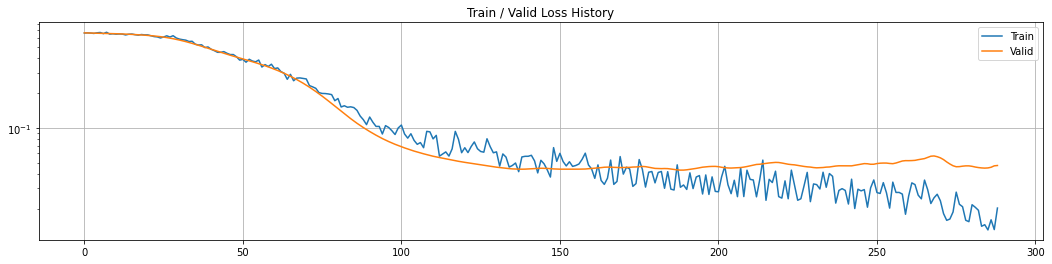

In [13]:
plot_from = 0

fig, ax = plt.subplots(1, 1, figsize=(18, 4))
plt.title('Train / Valid Loss History')
ax.plot(range(plot_from, len(train_history)), train_history[plot_from:],
         range(plot_from, len(valid_history)), valid_history[plot_from:])
plt.grid(True)
plt.yscale('log')
plt.legend(['Train', 'Valid'])
plt.show()

In [14]:
with torch.no_grad():
    X_ = X[2].split(batch_size, dim=0)
    y_ = y[2].split(batch_size, dim=0)

    test_loss = 0
    y_hat = []
    
    for X_i, y_i in zip(X_, y_):
        y_hat_i = model(X_i)
        loss = F.binary_cross_entropy(y_hat_i, y_i)

        test_loss += float(loss)
        y_hat += [y_hat_i]

test_loss = test_loss / len(X_)
y_hat = torch.concat(y_hat, dim=0)

sorted_history = sorted(zip(train_history, valid_history), key=lambda x: x[1])

print(f'Train loss: {sorted_history[0][0]:.4f}')
print(f'Valid loss: {sorted_history[0][1]:.4f}')
print(f'Test loss: {test_loss:.4f}')

Train loss: 0.0306
Valid loss: 0.0431
Test loss: 0.0539


In [15]:
correct_cnt = (y[2] == (y_hat > 0.5)).sum()
total_cnt = y[2].shape[0]

print(f'Test Accuracy: {correct_cnt / total_cnt:.2%}')

Test Accuracy: 99.13%


In [19]:
df = pd.DataFrame(torch.concat([y[2], y_hat > 0.5], dim=1).detach().numpy(), columns=['y', 'y_hat'])
df

,y,y_hat
0,1.0,1.0
1,1.0,1.0
2,0.0,0.0
3,0.0,0.0
4,1.0,1.0
...,...,...
110,0.0,0.0
111,0.0,0.0
112,1.0,1.0
113,1.0,1.0


In [20]:
roc_auc_score(df.values[:, 0], df.values[:, 1])

0.9874999999999999